# Support Vector Machines

A popular type of classification algorithm developed by the computer science community is the support vector machine. We now learn about this techinque.

## What we will accomplish

In this notebook we will:
- Discuss linear separability,
- Define the maximal margin classifier:
    - Provide the optimization problem that leads to its estimate and
    - Demonstrate implementaion in `sklearn`,
- Define the soft margin classifier:
    - Provide the optimization problem that leads to its estimate and
    - Demonstrate implementaion in `sklearn`,
- Mention the limitations of linear support vector machines,
- Give the intuition behind general support vector machines and
- Introduce the concept of a kernel function:
    - Discuss popular kernel functions for support vector machines.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a dark background
sns.set_style("whitegrid")

## Linear support vector machines

The first class of support vector machine (SVM) we will discuss is the <i>linear SVM</i>. These SVMs are designed with for data sets that are linearly separable or nearly linearly separable. A data set for a binary classification problem is said to be <i>linearly separable</i> if there is a hyperplane that separates the two classes. 

<i>If you are unfamiliar with the term hyperplane here is how to think about it, take a high dimensional space, any subspace that is one dimension lower is a hyperplane. So in $\mathbb{R}^1$ a hyperplane is a point, in $\mathbb{R}^2$ a hyperplane is a line, in $\mathbb{R}^3$ a hyperplane is a $2$-D plane, and in $\mathbb{R}^n$ it is an $n-1$ subspace.</i>

There are two types of linear SVMs.

### Maximal margin classifiers

We will start with what are sometimes referred to as <i>maximal margin classifiers</i>, for reasons we will understand soon.

Let's see some motivation first.

In [2]:
## Generate the random data
np.random.seed(440)
n_rows = 100
diff = .1
X = np.random.random((n_rows,2))
X_prime = X[(X[:,1] - X[:,0]) <= -diff,:]
X_2prime = X[(X[:,1] - X[:,0]) >= diff,:]

del X
X = np.append(X_prime,X_2prime,axis = 0)

y = np.empty(np.shape(X)[0])
y[(X[:,1] - X[:,0]) <= -diff] = 1
y[((X[:,1] - X[:,0]) >= diff)] = -1

X[1,:] = [.8,.1]

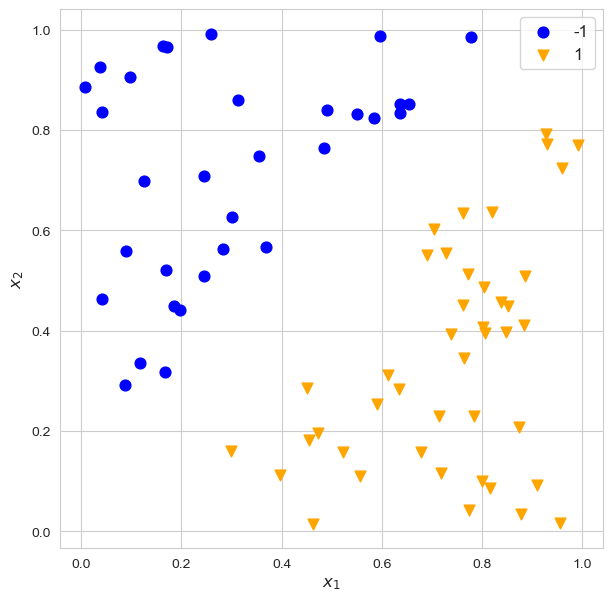

In [3]:
## Plot the data
plt.figure(figsize = (7,7))

plt.scatter(X[y == -1,0],
            X[y == -1,1],
            c = "blue",
            s = 60,
            label="-1")
plt.scatter(X[y == 1,0],
            X[y == 1,1],
            c = "orange",
            marker = 'v',
            s = 60,
            label="1")

plt.legend(fontsize = 12)
plt.xlabel("$x_1$",fontsize = 12)
plt.ylabel("$x_2$",fontsize = 12)

plt.show()

These classes appear to be linearly separable. The question becomes what is the best line with which to separate these points? That is what the maximal margin classifier finds! Below are three examples of separating lines.

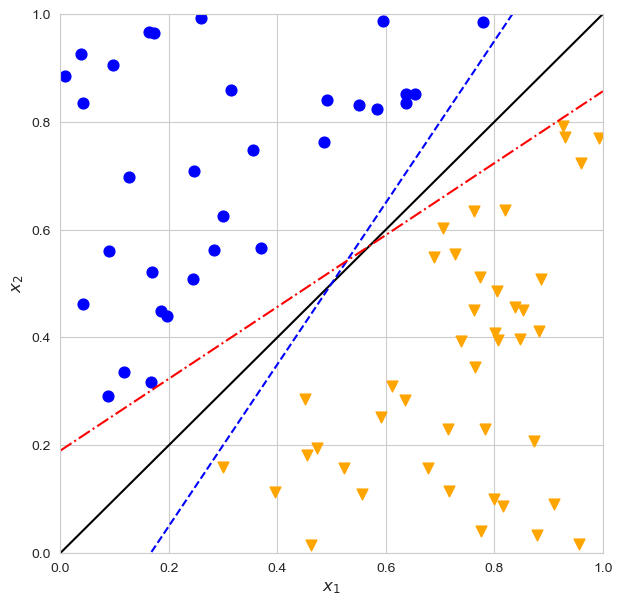

In [4]:
plt.figure(figsize = (7,7))

plt.scatter(X[y == -1,0],
            X[y == -1,1],
            c = "blue",
            s = 60,
            label="-1")
plt.scatter(X[y == 1,0],
            X[y == 1,1],
            c = "orange",
            marker = 'v',
            s = 60,
            label="1")

plt.plot(np.linspace(0,1,100),
         np.linspace(0,1,100),
         'k',
         label="x_2-x_1 = 0")
plt.plot(np.linspace(0,1,100),
         1.5*np.linspace(0,1,100)-.25,
         'b--',
         label="x_2-1.5x_1 = -0.25")
plt.plot(np.linspace(0,1,100),
         (1/1.5)*np.linspace(0,1,100)+.19,
         'r-.',
         label = "x_2-(1/1.5)x_1 = 0.19")


plt.xlabel("$x_1$",fontsize = 12)
plt.ylabel("$x_2$",fontsize = 12)

plt.xlim((0,1))
plt.ylim((0,1))

plt.show()

All three of these lines separate the two classes, but which one do you think will best generalize to future data points?

The red dot-dash and blue dotted lines get a bit to close to the training data at certain points. If we use one of those two lines, it is likely that new observations (which we would want to classify) will deviate to the wrong side of the decision boundary because of random noise. So what to do?

One approach is to draw a hyperplane that maximizes the total distance from all points to the hyperplane. Another way to think about it is to draw a hyperplane, find the minimum distance from the points to the hyperlane (known as the <i>margin</i>), then make that as large as possible (<i>maximize</i> it). Hence the name <i>maximal margin classifier</i>.

Let's formally define this classification algorithm, and then show how to implement it in python.

Suppose we have a binary variable, $y \in \left\lbrace -1,1 \right\rbrace$, and a set of $m$ features stored in the columns a feature matrix $X$. Then we can find the maximal margin classifier, if it exists, by solving the constrained optimization problem:

$$
\text{find } \beta \text{ and maximal } M, \text{ subject to}
$$

$$
||\beta||_2^2 = 1, \text{ and } 
$$

$$
y^{(i)}\left(X^{(i)} \beta\right) \geq M  \ \ \ \forall i = 1, \dots, n,
$$

where $\beta=\left(\beta_0, \beta_1, \dots, \beta_m \right)^T$ is a coefficient vector and $X$ has been extended to include a column of ones. It is possible to solve this optimization problem, but we will not touch on the details here. I include a reference for those looking to see how at the end of this notebook.

$ y^{(i)}\left(X^{(i)} \beta\right) \geq M $ may look weird, but $X \beta = 0$ is a formula that defines a hyperplane. 

For example:

$$
\beta_0 + \beta_1 X_1 + \beta_2 X_2 = 0 \text{ is the formula for a line in } 2\text{-D},
$$

$$
\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 = 0 \text{ is the formula for a plane in } 3\text{-D}.
$$

So $ y^{(i)}\left(X^{(i)} \beta\right) \geq M $ just establishes that we want all of our points to fall outside a margin of $M$ on either side of the hyperplane $X_i \beta=0$.

<i>Note: we are using $y\in \left\lbrace -1, 1 \right\rbrace$ rather than $y\in\left\lbrace 0, 1 \right\rbrace$ to conform with the standard formulation of the algorithm.</i>

#### `LinearSVC`

Let's now look at how to fit this model with `sklearn`. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html">https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html</a>.

In [5]:
## import LinearSVC
from sklearn.svm import LinearSVC

In [6]:
## make model
## For now please ignore C=1000 we will touch on it next,
## max_iter=100000 just increases the number of iterations for the fitting algorithm
max_margin = LinearSVC(C=1000, max_iter=100000)

## fit model
max_margin.fit(X, y)

/Users/stevengubkin/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=1000, max_iter=100000)

In [7]:
## This will allow me to plot the separating line
## along with the margins

# get a grid of x1 values
x1x1 = np.linspace(0, 1, 100)

# get a grid of x2 values
x2x2 = np.linspace(0, 1, 100)

# arrange them in a 2D grid
X1X1, X2X2 = np.meshgrid(x1x1, x2x2)

# make a cleaner array
x1x2 = np.vstack([X1X1.ravel(), X2X2.ravel()]).T

# get the value of the decision function for this grid
Z = max_margin.decision_function(x1x2).reshape(X1X1.shape)

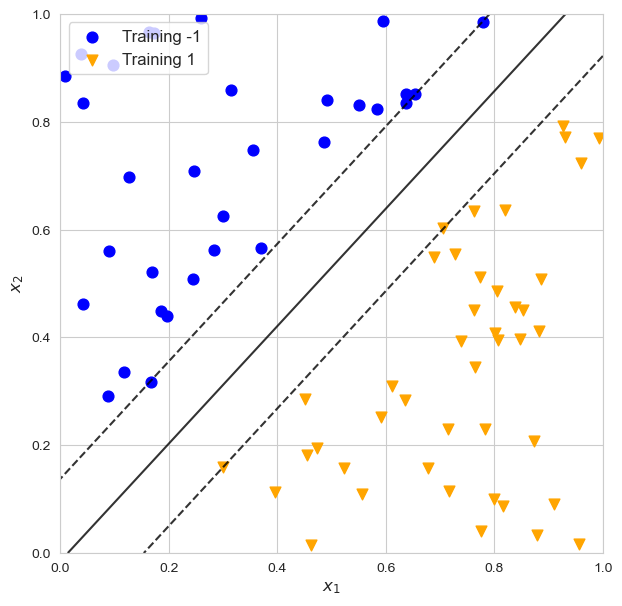

In [8]:
## Make a figure
plt.figure(figsize = (7,7))

## plot the training data
plt.scatter(X[y == -1,0],
            X[y == -1,1],
            c = "blue",
            s = 60,
            label="Training -1")
plt.scatter(X[y == 1,0],
            X[y == 1,1],
            c = "orange",
            marker = 'v',
            s = 60,
            label="Training 1")


## plot the separating line, and the margins
plt.contour(X1X1, 
            X2X2, 
            Z, 
            colors='k', 
            levels=[-1, 0, 1], 
            alpha=.8,
            linestyles=['--', '-', '--'])


plt.legend(fontsize=12, loc=2)

plt.xlabel("$x_1$",fontsize = 12)
plt.ylabel("$x_2$",fontsize = 12)

plt.xlim((0,1))
plt.ylim((0,1))

plt.show()

The solid line above is the separating line, and the dotted lines represent the line that is $M$ from the separating line at all points.

You can notice that some of the points touch the margin lines, such observations are known as the <i>support vectors</i> because they "support" the separating line in the sense that if we move these points slightly, the line will move as well.

### Support vector classifiers (or soft margin classifiers)

Okay so we now have an algorithm that can separate groups that are separable by hyperplanes. But, there are two possible issues:
- Your data may not be able to be separated by a hyperplane
- A maximum margin classifier may be too sensitive to training data

In [9]:
## Generate the random data
np.random.seed(440)
n_rows = 100
diff = .1
X = np.random.random((n_rows,2))
X_prime = X[(X[:,1] - X[:,0]) <= -diff,:]
X_2prime = X[(X[:,1] - X[:,0]) >= diff,:]
X_3prime = [[.4,.9],[.6,.45],[.7,.9],[.3,.19],[.1,.4]]

del X
X = np.append(X_prime,np.append(X_2prime,X_3prime,axis = 0),axis=0)

y = np.empty(np.shape(X)[0])
y[(X[:,1] - X[:,0]) <= -diff] = 1
y[((X[:,1] - X[:,0]) >= diff)] = -1
y[-5] = 1
y[-4] = -1
y[-3] = 1
y[-2] = -1
y[-1] = 1

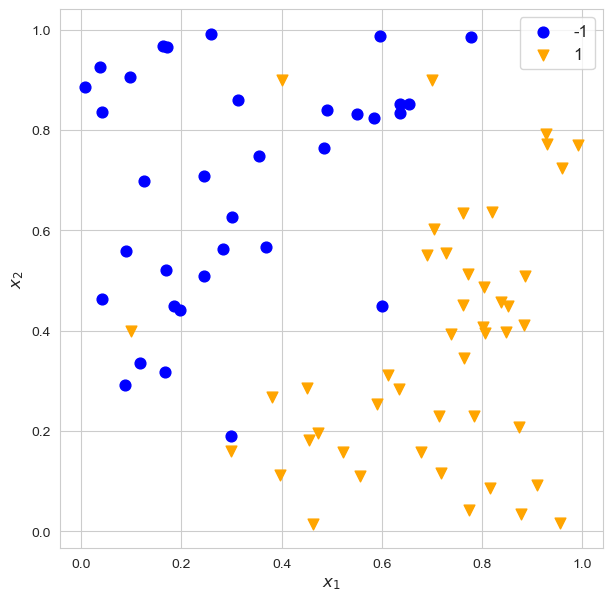

In [10]:
plt.figure(figsize = (7,7))

plt.scatter(X[y == -1,0],
            X[y == -1,1],
            c = "blue",
            s = 60,
            label="-1")
plt.scatter(X[y == 1,0],
            X[y == 1,1],
            c = "orange",
            s = 60,
            marker = "v",
            label="1")

plt.legend(fontsize = 12)
plt.xlabel("$x_1$",fontsize = 12)
plt.ylabel("$x_2$",fontsize = 12)

plt.show()

Is this new version of the data set linearly separable?

No.

But, they are <i>almost</i> linearly separable. 

If we are willing to not have a perfect separation we can still use the maximal margin classifier as our guide for a new algorithm.

#### Soften up the Margin Before Classifying

As we said before the maximal margin classifier is a <i>hard margin classifier</i>, meaning that instances of class $-1$ are not allowed to cross the decision boundary over into the area occupied by class $1$. But, what if we relaxed that rule.

Mathematically we can relax the rule with this new constrained optimization problem:

$$
\text{find } \beta \text{ and maximal } M, \text{ subject to}
$$

$$
||\beta||_2^2 = 1, \text{ and } 
$$

$$
y^{(i)}\left(X^{(i)} \beta\right) \geq M  (1-\epsilon^{(i)}) \ \ \ \forall i = 1, \dots, n,
$$

$$
\epsilon^{(i)} \geq 0, \ \sum_{i=1}^n \epsilon^{(i)} \leq \frac{1}{C},
$$

where $C\in \mathbb{R}_{>0}$ is a hyperparameter that you tune. The $\epsilon^{(i)}$ are referred to as slack variables because they control how much observation $i$ can violate the margin. If 

$$
\begin{array}{l l}
\epsilon^{(i)} = 0, & \text{ then observation } i \text{ is on the correct side of the margin.} \\
0 < \epsilon^{(i)} < 1, & \text{ then observation } i \text{ is on the wrong side of the margin, but the correct side of the hyperplane.} \\
\epsilon^{(i)} > 1, & \text{ then observation } i \text{ is on the incorrect side of the hyperplane.} \\
\end{array}
$$

The value of $C$ we choose can be thought of as our "budget" for slack variables. Larger values of $C$ lead to a smaller budget and so we approach the earlier maximum margin classifier, smaller values of $C$ allow for more slack. Let's demonstrate this with `sklearn`.

/Users/stevengubkin/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/stevengubkin/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/stevengubkin/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/stevengubkin/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.wa

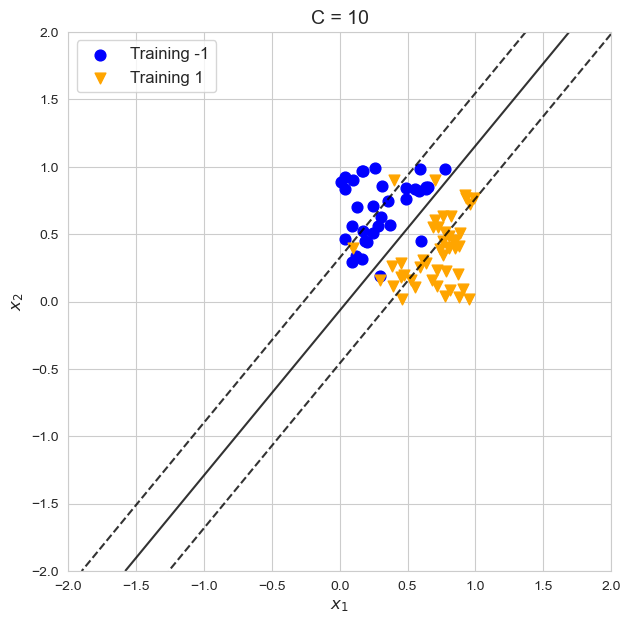

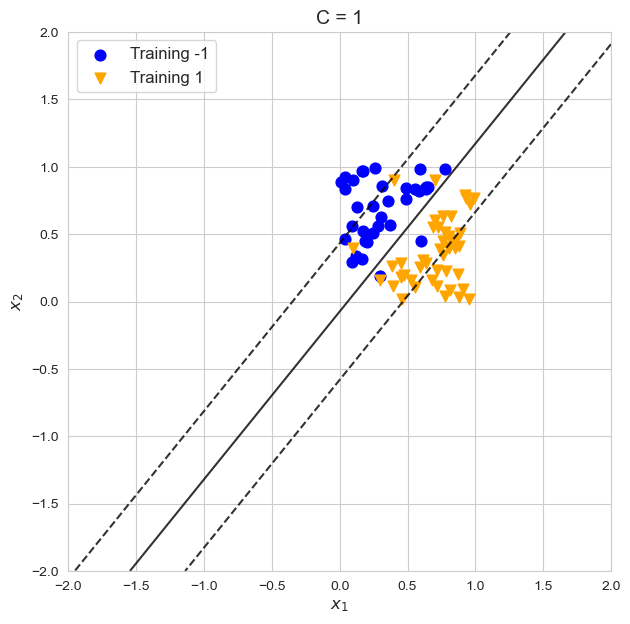

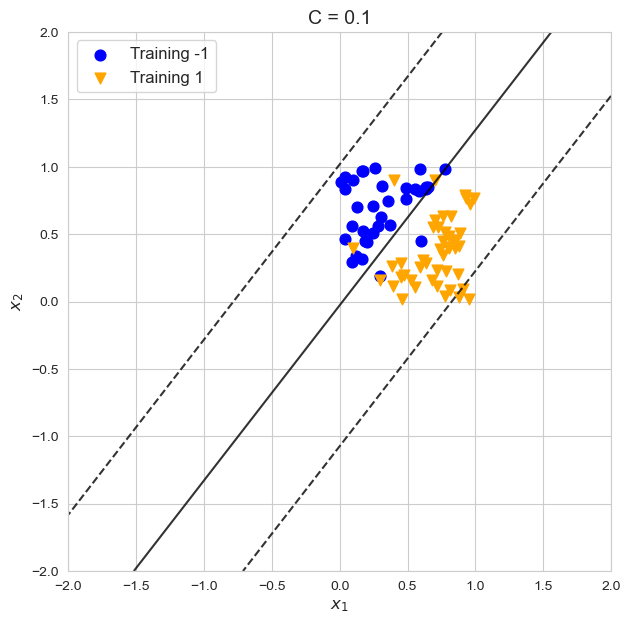

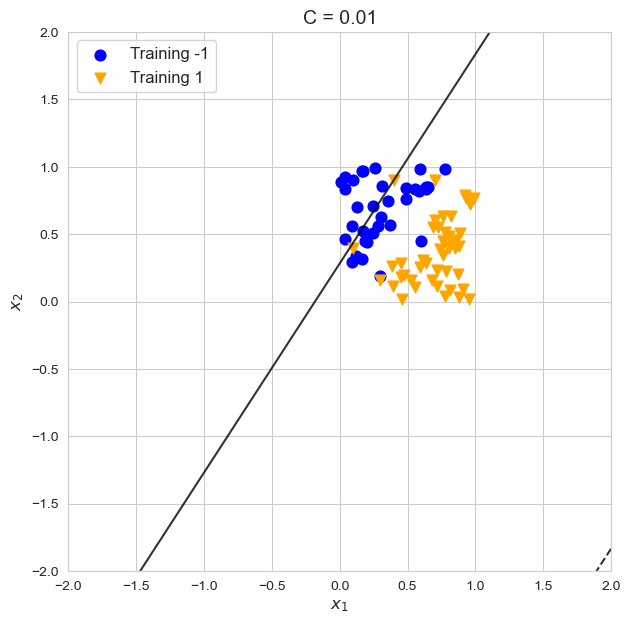

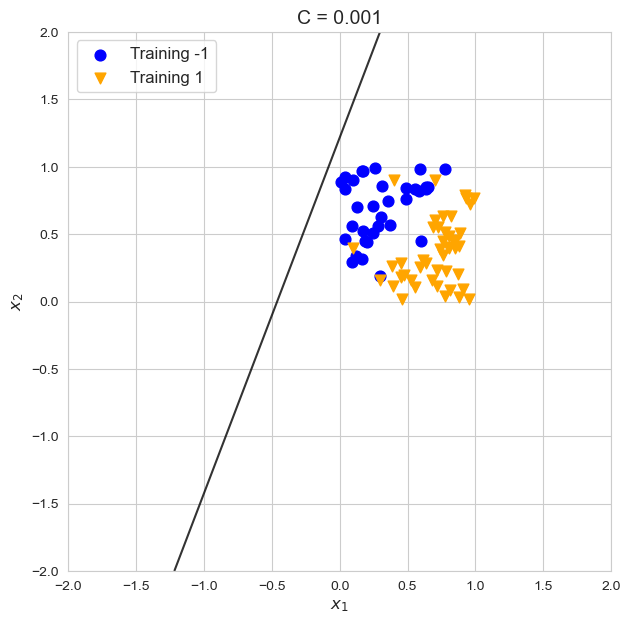

In [11]:
for C in [10,1,.1,.01,.001]:
    svc = LinearSVC(C=C, max_iter=100000)
    svc.fit(X, y)
    
    # get a grid of x1 values
    x1x1 = np.linspace(-2, 2, 100)

    # get a grid of x2 values
    x2x2 = np.linspace(-2, 2, 100)

    # arrange them in a 2D grid
    X1X1, X2X2 = np.meshgrid(x1x1, x2x2)

    # make a cleaner array
    x1x2 = np.vstack([X1X1.ravel(), X2X2.ravel()]).T

    # get the value of the decision function for this grid
    Z = svc.decision_function(x1x2).reshape(X1X1.shape)
    
    ## Make a figure
    plt.figure(figsize = (7,7))
    
    ## plot the training data
    plt.scatter(X[y == -1,0],
                X[y == -1,1],
                c = "blue",
                s = 60,
                label="Training -1")
    plt.scatter(X[y == 1,0],
                X[y == 1,1],
                c = "orange",
                marker = 'v',
                s = 60,
                label="Training 1")


    ## plot the separating line, and the margins
    plt.contour(X1X1, 
                X2X2, 
                Z, 
                colors='k', 
                levels=[-1, 0, 1], 
                alpha=.8,
                linestyles=['--', '-', '--'])


    plt.legend(fontsize=12, loc=2)

    plt.xlabel("$x_1$",fontsize = 12)
    plt.ylabel("$x_2$",fontsize = 12)
    
    plt.title("C = " + str(C), fontsize=14)

$C$ is a hyperparameter and the value of $C$ that works best for your problem can be determined via hyperparameter tuning with cross-validation.

For the support vector classifier we consider any point that touches or is on the wrong side of the margin a <i>support vector</i>, that is because these are the observations for which $\epsilon^{(i)} > 0$. Again these are called support vectors because they "support" the decision boundary in a sense. If we were to move one of these support vectors the boundary would change. On the other hand if we moved a non-support vector, the boundary would remain the same (assuming we don't move it too far!).

## General support vector machines

### Nonlinear decision boundaries

Another issue for the linear SVMs we have discussed is the situation where our data are only separably by a nonlinear decision boundary.

For example,

In [12]:
## Generate the random data
np.random.seed(440)

X = np.zeros((300, 2))
X[:100,0] = np.random.randn(100)
X[:100,1] = np.random.randn(100)
X[100:200,0] = np.random.randn(100) + 4.5
X[100:200,1] = np.random.randn(100) + 4.5
X[200:,0] = np.random.randn(100) - 4.5
X[200:,1] = np.random.randn(100) - 4.5

y = np.zeros(300) - 1
y[:100] = 1

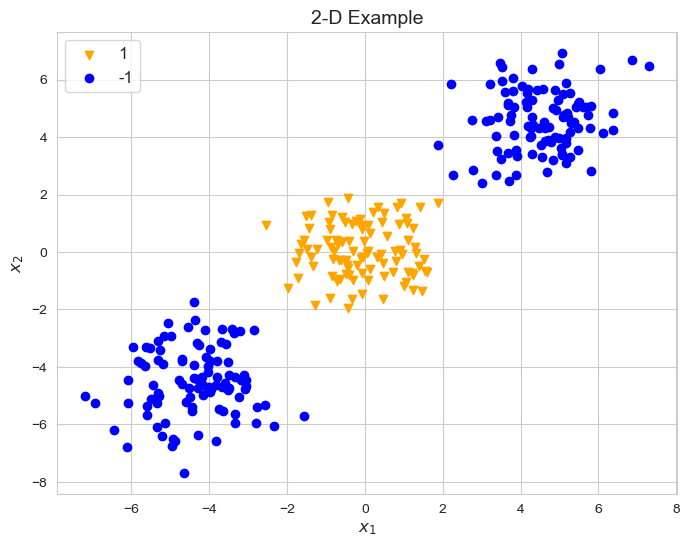

In [13]:
plt.figure(figsize=(8,6))


plt.scatter(X[y==1,0], 
            X[y==1,1], 
            c='orange',
            marker = 'v',
            label="1")
plt.scatter(X[y==-1,0], 
            X[y==-1,1], 
            c='blue', 
            label="-1")

plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.legend(fontsize=12)
plt.title("2-D Example", fontsize=14)

plt.show()

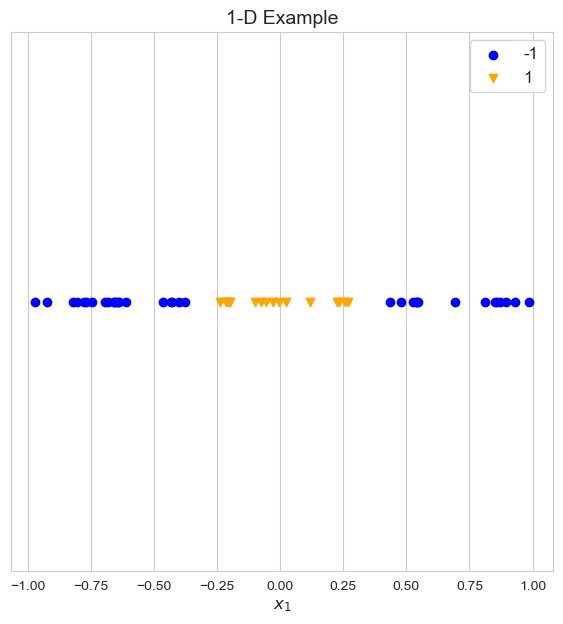

In [14]:
np.random.seed(440)

X = 2*np.random.random(50) - 1
y = np.ones(len(X))
y[(X > .3) | (X < -.3)] = -1

plt.figure(figsize=(7,7))


plt.scatter(X[y==-1],
            np.ones(sum(y==-1)),
            c="blue",
            label="-1")
plt.scatter(X[y==1],
            np.ones(sum(y==1)),
            c="orange",
            marker = 'v',
            label="1")
plt.yticks([])

plt.legend(fontsize=12)
plt.xlabel("$x_1$",fontsize=12)

plt.title("1-D Example", fontsize=14)

plt.show()

Both of these examples cannot be separated by any linear decision boundary. So what can we do?

### Lifting to higher dimensions

While these examples cannot be linearly separated (or near linearly separated) in their current dataspace, we can separate them if "lift them" into a higher dimensional space in the correct way. Let's see an example with the $1$-D data set.

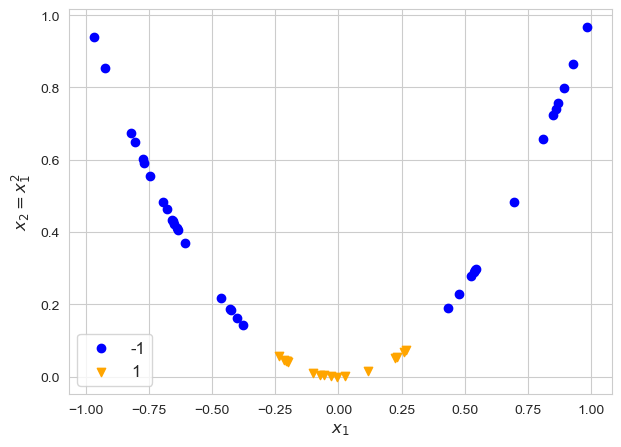

In [15]:
## Add a feature x_2 to X, that is just x_1^2
## make sure it is an np array with the first column as x_1
## and the second column as x_2
X_new = np.zeros((len(X),2))
X_new[:,0] = X.copy()
X_new[:,1] = X**2

## Now plot it using the below code
plt.figure(figsize=(7,5))


plt.scatter(X_new[y==-1,0],
            X_new[y==-1,1],
            c="blue",
            label="-1")
plt.scatter(X_new[y==1,0],
            X_new[y==1,1],
            c="orange",
            marker='v',
            label="1")


plt.legend(fontsize=12)
plt.xlabel("$x_1$",fontsize=12)
plt.ylabel("$x_2 = x_1^2$",fontsize=12)

plt.show()

In [16]:
## Fit a LinearSVC here
svc = LinearSVC(C=100, max_iter=100000)


svc.fit(X_new, y)

/Users/stevengubkin/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=100, max_iter=100000)

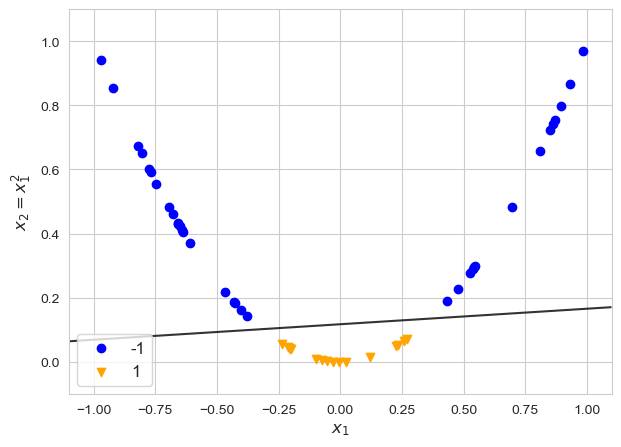

In [17]:
# get a grid of x1 values
x1x1 = np.linspace(-1.1, 1.1, 100)

# get a grid of x2 values
x2x2 = np.linspace(-.1, 1.1, 100)

# arrange them in a 2D grid
X1X1, X2X2 = np.meshgrid(x1x1, x2x2)

# make a cleaner array
x1x2 = np.vstack([X1X1.ravel(), X2X2.ravel()]).T

# get the value of the decision function for this grid
Z = svc.decision_function(x1x2).reshape(X1X1.shape)


## Now plot it using the below code
plt.figure(figsize=(7,5))


plt.scatter(X_new[y==-1,0],
            X_new[y==-1,1],
            c="blue",
            label="-1")
plt.scatter(X_new[y==1,0],
            X_new[y==1,1],
            c="orange",
            marker = 'v',
            label="1")

plt.contour(X1X1, 
            X2X2, 
            Z, 
            colors='k', 
            levels=[0], 
            alpha=.8, 
            linestyles=['-'])


plt.legend(fontsize=12)
plt.xlabel("$x_1$",fontsize=12)
plt.ylabel("$x_2 = x_1^2$",fontsize=12)

plt.show()

This trick is the essence of the more general support vector machine. We take data in a lower dimension, somehow embed it into a higher dimension where it is hopefully close to linearly separable.

However, one issue that arises is how to choose such an embedding. Should we arbitrarily add powers and interactions of features? What about some nonlinear transformations? In this process we could easily end up with a magnitude of potential features, which in turn would cause our computational cost to skyrocket. Luckily support vector machines have a nice way to handle such a problem.

### Kernel functions

While we have not explicitly discussed how the solution to the support vector classifier is computed, because it is  a bit long and technical, it turns out that it solely involves inner products between the training observations. For SVMs the inner product between two vectors $a,b\in \mathbb{R}^m$ is computed as:

$$
\left\langle a,b \right\rangle = \sum_{i=1}^m a_i b_i.
$$

So if we have some function, $\phi$ that takes our observations into a higher dimensionall space in order to separate them, then we will need to  compute $\left\langle \phi(X^*), \phi(X^\#) \right\rangle$ for pairs of observations $X^*$ and $X^\#$ (in actuality our computer will do this for us). $\phi$ can ultimately take our lower dimensional data into very very high dimensional space, even spaces which are considered infinite dimensional. This would make it nearly impossible (or actually impossible) to compute the inner products needed to estimate the separating boundary. But, what if we did not need to actually compute $\left\langle \phi(X^*), \phi(X^\#) \right\rangle$ in the higher dimensional space? Let's look at an example:

Let's say our data has two features $x_1$ and $x_2$ and our $\phi$ is like so:
$$
\phi\left(\left(.\begin{array}{c} x_1 \\ x_2 \end{array} \right)\right) = \left(\begin{array}{c} x_1^2 \\ \sqrt{2} x_1 x_2 \\ x_2^2 \end{array} \right).
$$
For two vectors $a$ and $b$ the inner product between $\phi(a)$ and $\phi(b)$ is:
$$
\left\langle \phi(a) , \phi(b) \right\rangle= a_1^2 b_1^2 + 2 a_1b_1a_2b_2 + a_2^2b_2^2 = (a_1 b_1 + a_2 b_2)^2 = \left\langle  a,b\right\rangle^2
$$

So even though we knew what the map $\phi$ was to the higher space, we didn't need to know what it was to compute the dot product $\left\langle \phi(a) , \phi(b) \right\rangle$!

In this context we say a map $\phi$ has a <i>kernel function</i>, $K$, if $\left\langle \phi(a) , \phi(b) \right\rangle = K(a,b)$ where $K$ is only a function of $a$ and $b$ in the original feature space. So for the example mapping we looked at the kernel function is $K(a,b) = (\left\langle  a,b\right\rangle)^2$.

Common kernel functions for support vector machines are:
- Linear, $K(a,b) = \left\langle  a,b\right\rangle$, this gives the linear classifiers we looked at earlier,
- Polynomial, $K(a,b) = (\gamma \left\langle  a,b\right\rangle + r)^d$, where $\gamma$ is a hyperparameter to be tuned,
- Gaussian Radial Kernel (Gaussian RBF), $K(a,b) = \exp\left( -\gamma ||a-b||^2 \right)$, where $||\bullet ||$ is the Euclidean norm,
- Sigmoid, $K(a,b) = \tanh(\gamma \left\langle  a,b\right\rangle + r)$


Let's now demonstrate how to implement this in `sklearn` using our two examples from above.

We will be using `SVC` from `sklearn.svm`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC">https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC</a>.

In [18]:
## import SVC
from sklearn.svm import SVC

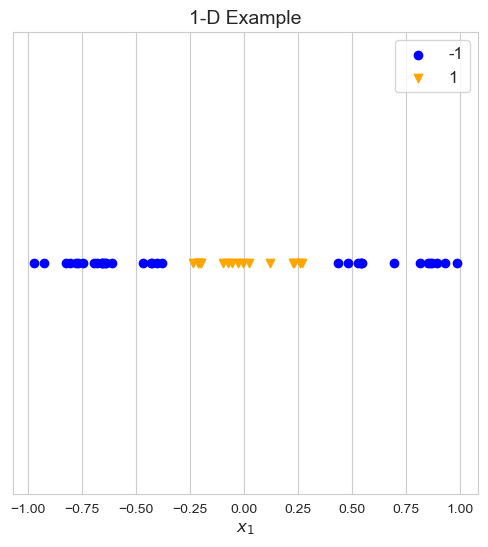

In [19]:
## Now plot it using the below code
plt.figure(figsize=(6,6))


plt.scatter(X[y==-1],
            np.ones(sum(y==-1)),
            c="blue",
            label="-1")
plt.scatter(X[y==1],
            np.ones(sum(y==1)),
            c="orange",
            marker = 'v',
            label="1")
plt.yticks([])

plt.legend(fontsize=12)
plt.xlabel("$x_1$",fontsize=12)

plt.title("1-D Example", fontsize=14)

plt.show()

In [20]:
## make a model
## Set kernel = 'poly', degree = 2, C = 1000
svc = SVC(kernel='poly', degree=2, C=1000)

## fit a model
svc.fit(X.reshape(-1,1), y)

SVC(C=1000, degree=2, kernel='poly')

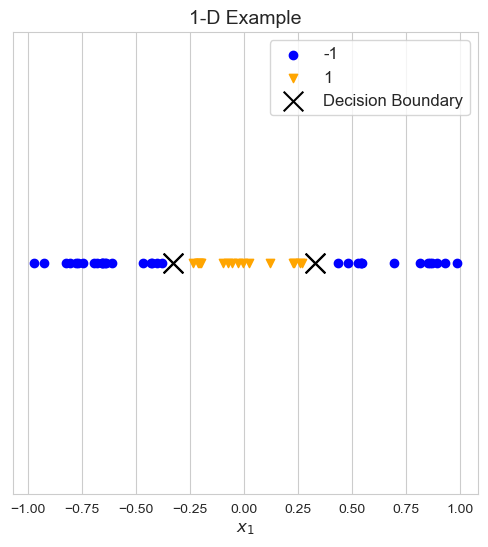

In [21]:
plt.figure(figsize=(6,6))


plt.scatter(X[y==-1],
            np.ones(sum(y==-1)),
            c="blue",
            label="-1")
plt.scatter(X[y==1],
            np.ones(sum(y==1)),
            c="orange",
            marker = 'v',
            label="1")
plt.yticks([])

decs = svc.decision_function(np.linspace(-1,1,1000).reshape(-1,1)).round(1)
plt.scatter(np.linspace(-1,1,1000)[decs==0], 
            np.ones(1000)[decs==0], 
            marker = 'x', 
            s=200, c='k', 
            label="Decision Boundary")

plt.legend(fontsize=12)
plt.xlabel("$x_1$",fontsize=12)



plt.title("1-D Example", fontsize=14)

plt.show()

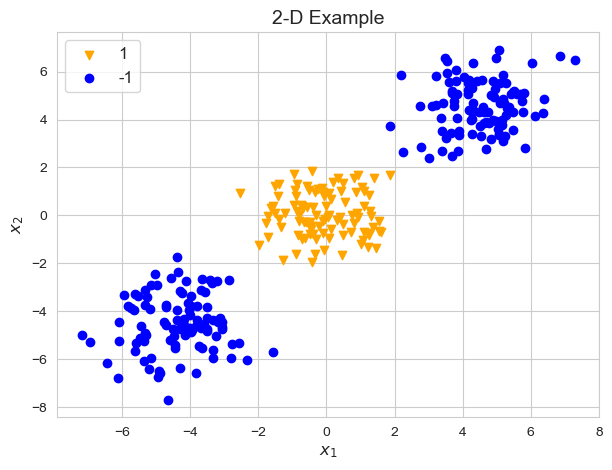

In [22]:
## Generate the random data
np.random.seed(440)

X = np.zeros((300, 2))
X[:100,0] = np.random.randn(100)
X[:100,1] = np.random.randn(100)
X[100:200,0] = np.random.randn(100) + 4.5
X[100:200,1] = np.random.randn(100) + 4.5
X[200:,0] = np.random.randn(100) - 4.5
X[200:,1] = np.random.randn(100) - 4.5

y = np.zeros(300)-1
y[:100] = 1

plt.figure(figsize=(7,5))


plt.scatter(X[y==1,0], 
            X[y==1,1], 
            c='orange', 
            marker='v',
            label="1")
plt.scatter(X[y==-1,0], 
            X[y==-1,1], 
            c='blue', 
            label="-1")

plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.legend(fontsize=12)
plt.title("2-D Example", fontsize=14)

plt.show()

In [23]:
## make two new svc models

## one with poly, degree=2, C = 10
svc_poly = SVC(kernel='poly', degree=2, C=10)

## one with rbf kernel, C = 10
svc_rbf = SVC(kernel = 'rbf', C=10)


## fit a model
svc_poly.fit(X, y)
svc_rbf.fit(X,y)

SVC(C=10)

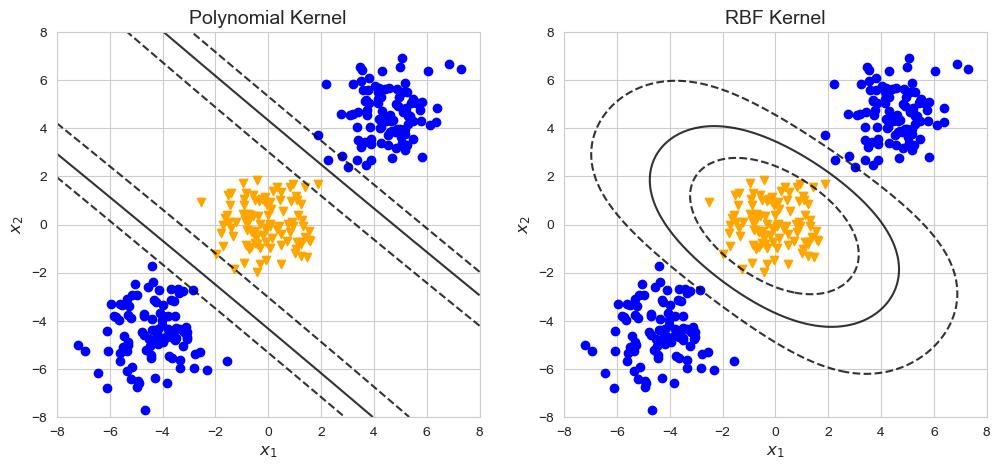

In [24]:
fig,ax = plt.subplots(1,2,figsize=(12,5))


ax[0].scatter(X[y==1,0], 
              X[y==1,1], 
              c='orange', 
              marker='v',
              label="1")
ax[0].scatter(X[y==-1,0], 
              X[y==-1,1], 
              c='blue', 
              label="-1")

ax[1].scatter(X[y==1,0], 
              X[y==1,1], 
              c='orange', 
              marker='v',
              label="1")
ax[1].scatter(X[y==-1,0], 
              X[y==-1,1], 
              c='blue', 
              label="-1")


# get a grid of x1 values
x1x1 = np.linspace(-8, 8, 100)

# get a grid of x2 values
x2x2 = np.linspace(-8, 8, 100)

# arrange them in a 2D grid
X1X1, X2X2 = np.meshgrid(x1x1, x2x2)

# make a cleaner array
x1x2 = np.vstack([X1X1.ravel(), X2X2.ravel()]).T

# get the value of the decision function for this grid
Z_poly = svc_poly.decision_function(x1x2).reshape(X1X1.shape)
Z_rbf = svc_rbf.decision_function(x1x2).reshape(X1X1.shape)


ax[0].contour(X1X1, X2X2, Z_poly,
              colors='k', levels=[-1,0,1], 
              alpha=.8, linestyles=['--','-','--'])
ax[1].contour(X1X1, X2X2, Z_rbf,
              colors='k', levels=[-1,0,1], 
              alpha=.8, linestyles=['--','-','--'])

ax[0].set_title("Polynomial Kernel", fontsize=14)
ax[1].set_title("RBF Kernel", fontsize=14)

ax[0].set_xlabel("$x_1$", fontsize=12)
ax[1].set_xlabel("$x_1$", fontsize=12)
ax[0].set_ylabel("$x_2$", fontsize=12)
ax[1].set_ylabel("$x_2$", fontsize=12)

plt.show()

### References for mathematical details

- Chapter 4 of Elements of Statistical Learning for the maximum margin classifier,
- Chapter 12 of Elements of Statistical Learning for the support vector classifier and
- Chapter 12 of Elements of Statistical Learning for the general support vector machine.

<a href="https://web.stanford.edu/~hastie/ElemStatLearn/">https://web.stanford.edu/~hastie/ElemStatLearn/</a>

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)